In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import random
from itertools import chain as chain
from torch.distributions.multivariate_normal import MultivariateNormal
import math


cudaOn = False

In [2]:
#Data preparation

In [3]:
data = "C:/Users/Charlie/Downloads/NGAFID_MC_C37/NGAFID_MC_C37.csv"
data = pd.read_csv(data)
data = data.fillna(0.0)

scaler = MinMaxScaler()

In [4]:
data

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split,date_diff,before_after
0,27.9,27.9,7.9,0.7,24.00,24.00,2.09,129.2,61.16,1191.0,...,7.2,0.0,15.74,-0.02,822.5,2,18,4,-2,1
1,27.9,27.9,7.9,0.6,24.00,24.00,2.13,129.2,61.20,1192.0,...,7.2,0.0,11.13,-0.00,822.5,2,18,4,-2,1
2,27.9,28.0,8.0,0.6,24.00,24.00,2.07,129.2,61.03,1186.0,...,7.2,0.0,-0.85,0.00,0.0,2,18,4,-2,1
3,27.9,27.9,7.8,0.6,24.00,24.00,2.12,129.2,61.16,1190.0,...,7.2,0.0,-30.64,-0.03,824.5,2,18,4,-2,1
4,27.9,27.9,7.7,0.6,24.00,24.00,2.08,129.1,61.25,1197.0,...,7.2,0.0,-23.95,-0.02,825.0,2,18,4,-2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13414562,26.6,26.7,-6.7,-0.0,14.81,19.02,1.26,152.2,52.60,764.5,...,19.5,0.0,5.91,0.06,836.0,6083,19,0,-1,1
13414563,26.5,26.6,-5.9,-0.0,14.81,19.02,1.28,152.2,52.72,771.5,...,19.5,0.0,15.54,-0.02,836.0,6083,19,0,-1,1
13414564,26.4,26.5,-5.3,-0.0,14.81,19.02,1.25,152.2,52.66,770.0,...,19.5,0.0,15.99,-0.01,836.0,6083,19,0,-1,1
13414565,26.3,26.4,-4.8,-0.0,14.86,19.05,1.26,152.2,52.66,769.0,...,19.5,0.0,7.91,0.03,836.0,6083,19,0,-1,1


In [5]:
data = data.drop('date_diff',axis=1)
dataBefore = data[(data['before_after']==0)]
dataAfter = data[(data['before_after']==1)]
dataBefore = dataBefore.drop('before_after',axis=1)
dataAfter = dataAfter.drop('before_after',axis=1)

In [6]:
dataBefore

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split
18830,27.9,27.9,14.1,0.5,21.90,20.88,2.05,153.5,56.94,1172.0,...,1144.0,1186.0,28.5,0.0,-44.22,0.01,828.0,5,56,0
18831,27.9,27.9,14.0,0.5,21.90,20.88,2.07,153.5,57.03,1179.0,...,1144.0,1187.0,28.5,0.0,-48.10,-0.02,842.5,5,56,0
18832,27.9,27.9,14.1,0.5,21.90,20.88,2.07,153.4,57.47,1180.0,...,1145.0,1191.0,28.5,0.0,-29.27,0.03,0.0,5,56,0
18833,27.9,27.9,13.8,0.5,21.90,20.84,2.08,153.4,57.00,1171.0,...,1147.0,1192.0,28.5,0.0,8.83,0.02,841.5,5,56,0
18834,27.9,27.9,13.9,0.5,21.84,20.88,2.10,153.4,56.22,1147.0,...,1150.0,1195.0,28.5,0.0,14.45,-0.01,842.0,5,56,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13408311,28.0,28.1,0.3,-0.1,14.35,15.85,2.29,157.9,58.40,1054.0,...,1071.0,1104.0,26.2,0.0,-4.50,-0.03,708.0,6082,43,1
13408312,28.0,28.1,0.3,-0.1,14.35,15.80,2.34,157.9,58.38,1051.0,...,1072.0,1103.0,26.2,0.0,12.29,0.00,708.0,6082,43,1
13408313,28.1,28.1,0.3,-0.1,14.47,15.75,2.25,157.9,58.22,1050.0,...,1072.0,1104.0,26.2,0.0,24.31,-0.01,707.0,6082,43,1
13408314,28.1,28.1,0.3,-0.0,14.47,15.70,2.27,157.9,58.20,1054.0,...,1072.0,1105.0,26.2,0.0,2.90,0.01,707.5,6082,43,1


In [7]:
dataAfter

,volt1,volt2,amp1,amp2,FQtyL,FQtyR,E1 FFlow,E1 OilT,E1 OilP,E1 RPM,...,E1 EGT3,E1 EGT4,OAT,IAS,VSpd,NormAc,AltMSL,id,plane_id,split
0,27.9,27.9,7.9,0.7,24.00,24.00,2.09,129.2,61.16,1191.0,...,1112.0,1255.0,7.2,0.0,15.74,-0.02,822.5,2,18,4
1,27.9,27.9,7.9,0.6,24.00,24.00,2.13,129.2,61.20,1192.0,...,1114.0,1257.0,7.2,0.0,11.13,-0.00,822.5,2,18,4
2,27.9,28.0,8.0,0.6,24.00,24.00,2.07,129.2,61.03,1186.0,...,1119.0,1261.0,7.2,0.0,-0.85,0.00,0.0,2,18,4
3,27.9,27.9,7.8,0.6,24.00,24.00,2.12,129.2,61.16,1190.0,...,1125.0,1267.0,7.2,0.0,-30.64,-0.03,824.5,2,18,4
4,27.9,27.9,7.7,0.6,24.00,24.00,2.08,129.1,61.25,1197.0,...,1129.0,1271.0,7.2,0.0,-23.95,-0.02,825.0,2,18,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13414562,26.6,26.7,-6.7,-0.0,14.81,19.02,1.26,152.2,52.60,764.5,...,1001.0,989.5,19.5,0.0,5.91,0.06,836.0,6083,19,0
13414563,26.5,26.6,-5.9,-0.0,14.81,19.02,1.28,152.2,52.72,771.5,...,998.5,988.0,19.5,0.0,15.54,-0.02,836.0,6083,19,0
13414564,26.4,26.5,-5.3,-0.0,14.81,19.02,1.25,152.2,52.66,770.0,...,995.0,987.0,19.5,0.0,15.99,-0.01,836.0,6083,19,0
13414565,26.3,26.4,-4.8,-0.0,14.86,19.05,1.26,152.2,52.66,769.0,...,990.5,986.5,19.5,0.0,7.91,0.03,836.0,6083,19,0


In [8]:
numVariables = 26

In [9]:
#Helper Methods

In [27]:
#Split and reshape the data set by step_size , use min-max or stanrdardlize method to rescale the data
def Splitting_dataset(data, step_size, scale=True, scaler_type=MinMaxScaler):
        l = len(data) 
        data = scaler_type().fit_transform(data)
        Xs = []
        Ys = []
        for i in range(0, (len(data) - step_size)):
            Xs.append(data[i:i+step_size])
            Ys.append(data[i:i+step_size])
        train_x, test_x, train_y, test_y = [np.array(x) for x in train_test_split(Xs, Ys)]
        assert train_x.shape[2] == test_x.shape[2] == (data.shape[1] if (type(data) == np.ndarray) else len(data))
        return  (train_x.shape[2], train_x, train_y, test_x, test_y)
    
    
def get_batch(x, batch_size):
    """Made with taking test_x or XX as input"""
    #make stochastic
    t = 0
    while t >= 0:
        x_mod = len(x) % batch_size
        start = random.random() * (len(x)-x_mod)
        start = int(start)
        if start + batch_size < len(x):
            t = t-1
    batch = torch.tensor(x[start:(start+batch_size)]) #!! added tensor line
    #print(batch.shape)
    return batch


def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)


def loss_fn(recon_x, x, mu, logvar):
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    BCE = F.binary_cross_entropy(recon_x, x, size_average=True)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

    
def tep_testing_stepped(dat,step_size):
    res = []
    ind = 0
    scale = MinMaxScaler().fit(dat)
    dat = pd.DataFrame(scale.transform(dat))
    for i in range(int((len(dat)/step_size))):
        if ind + step_size < len(dat):
            step = []
            for j in range(step_size):
              step.append(dat.iloc(0)[ind])
              ind = ind + 1
            res.append(step)
    return res

In [11]:
#Model

In [12]:
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=27, z_dim=31, n_flow_steps=1):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(image_size, h_dim),
            nn.LeakyReLU(0.1),
            nn.Linear(h_dim, z_dim*2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, image_size),
            nn.Sigmoid()
        )

    
    def reparameterize(self, mu, logvar):
        mu.double()
        logvar.double()
        std = logvar.mul(0.5).exp_() 
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        
        return z
    
    def forward(self, x):
        h = self.encoder(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        z = model(z)
        tensorZ = torch.tensor(z[0])
        
        return self.decoder(tensorZ), mu, logvar
    

class stacked_NVP(nn.Module):
    def __init__(self, d, k, hidden, n):
        super().__init__()
        self.bijectors = nn.ModuleList([
            R_NVP(d, k, hidden=hidden) for _ in range(n)
        ])
        self.flips = [True if i%2 else False for i in range(n)]
        
    def forward(self, x):
        log_jacobs = []

        for bijector, f in zip(self.bijectors, self.flips):
            x, log_pz, lj = bijector(x, flip=f)
            log_jacobs.append(lj)
        
        return x, log_pz, sum(log_jacobs)
    
    def inverse(self, z):
        for bijector, f in zip(reversed(self.bijectors), reversed(self.flips)):
            z = bijector.inverse(z, flip=f)
        return z
    
    
class R_NVP(nn.Module):
    def __init__(self, d, k, hidden):
        super().__init__()
        self.d, self.k = d, k
        self.sig_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        self.mu_net = nn.Sequential(
                    nn.Linear(k, hidden),
                    nn.LeakyReLU(),
                    nn.Linear(hidden, d - k))

        
    def forward(self, x, flip=False):
        x1, x2 = x[:, :self.k], x[:, self.k:] 
        
        if flip:
            x2, x1 = x1, x2
            
        sig = self.sig_net(x1)
        z1, z2 = x1, x2 * torch.exp(sig) + self.mu_net(x1)
        
        if flip:
            z2, z1 = z1, z2

        z_hat = torch.cat([z1, z2], dim=-1)

        log_pz = base_dist.log_prob(z_hat)
        log_jacob = sig.sum(-1)
        
        return z_hat, log_pz, log_jacob
    
    
    def inverse(self, Z, flip=False):
        z1, z2 = Z[:, :self.k], Z[:, self.k:] 
        
        if flip:
            z2, z1 = z1, z2
        
        x1 = z1
        x2 = (z2 - self.mu_net(z1)) * torch.exp(-self.sig_net(z1))
        
        if flip:
            x2, x1 = x1, x2
        return torch.cat([x1, x2], -1)

In [13]:
#Model Setup

In [14]:
step_size = 3
batch = 512
index_step_length = numVariables
epochs = 20

num = 5

d = numVariables
k = int(numVariables/2)

base_mu, base_cov = torch.zeros(numVariables), torch.eye(numVariables)

base_mu = torch.nn.parameter.Parameter(to_var(base_mu.double()))
base_cov = torch.nn.parameter.Parameter(to_var(base_cov.double()))

base_dist = MultivariateNormal(base_mu, base_cov)
#---------------------------------------------------------------------------------------------------------------------------------
labels, X, Y, XX, YY = Splitting_dataset(dataBefore, step_size)

demo = VAE(index_step_length,h_dim=13,z_dim=numVariables)
model = stacked_NVP(d, k, hidden=512,n=num)
demo.double()
model.double()
    
optimizer = torch.optim.RMSprop(model.parameters(), lr=1e-3)
optimizer2 = torch.optim.Adam(demo.parameters(), lr=1e-3)
optimizer3 = torch.optim.RMSprop([base_mu,base_cov], lr=1e-3)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.999)

In [15]:
#Model Training

In [16]:
idx = 0

anomaly_history = []
loss_history = []
avgSum = 0
avgCount = 0

for epoch in range(epochs):
    b = get_batch(X,batch)
    
    for i in range(batch):
        optimizer.zero_grad()
        optimizer2.zero_grad()
        optimizer3.zero_grad()
        localX = to_var(torch.tensor(b[i]))
        recon, mu, logvar = demo(localX)
        loss = loss_fn(recon, localX, mu, logvar) #doing kl-divergence loss correctly
        """This bound (kl loss) provides a unified objective function for 
        op-timization of both the parameters θ and φ of the model and variational approximation, respectively."""
        loss.backward()
        
        optimizer.step()
        optimizer2.step()
        optimizer3.step()
        scheduler.step()

        idx = idx + 1

        avgSum = avgSum + torch.mean(loss/batch)
        avgCount = avgCount + 1
        anomaly_score = abs(torch.mean(localX-recon))

        if idx%step_size == 0:
            loss_history.append(avgSum/avgCount)
            anomaly_history.append(anomaly_score)
            avgSum = 0
            avgCount = 0

        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.data.item()/batch))

C:\Users\Charlie\AppData\Local\Temp/ipykernel_29272/2088469916.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  localX = to_var(torch.tensor(b[i]))
C:\Users\Charlie\AppData\Local\Temp/ipykernel_29272/3844283621.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensorZ = torch.tensor(z[0])
C:\Users\Charlie\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Epoch[1/20] Loss: 0.001
Epoch[1/20] Loss: 0.001
Epoch[1/20] Loss: 0.001
Epoch[1/20] Loss: 0.001
Epoch[1/20] Loss: 0.001
Epoch[2/20] Loss: 0.001
Epoch[2/20] Loss: 0.001
Epoch[2/20] Loss: 0.001
Epoch[2/20] Loss: 0.001
Epoch[2/20] Loss: 0.001
Epoch[3/20] Loss: 0.001
Epoch[3/20] Loss: 0.001
Epoch[3/20] Loss: 0.001
Epoch[3/20] Loss: 0.001
Epoch[3/20] Loss: 0.001
Epoch[4/20] Loss: 0.001
Epoch[4/20] Loss: 0.001
Epoch[4/20] Loss: 0.001
Epoch[4/20] Loss: 0.001
Epoch[4/20] Loss: 0.001
Epoch[5/20] Loss: 0.001
Epoch[5/20] Loss: 0.001
Epoch[5/20] Loss: 0.001
Epoch[5/20] Loss: 0.001
Epoch[5/20] Loss: 0.001
Epoch[6/20] Loss: 0.001
Epoch[6/20] Loss: 0.001
Epoch[6/20] Loss: 0.001
Epoch[6/20] Loss: 0.001
Epoch[6/20] Loss: 0.001
Epoch[7/20] Loss: 0.001
Epoch[7/20] Loss: 0.001
Epoch[7/20] Loss: 0.001
Epoch[7/20] Loss: 0.001
Epoch[7/20] Loss: 0.001
Epoch[8/20] Loss: 0.001
Epoch[8/20] Loss: 0.001
Epoch[8/20] Loss: 0.001
Epoch[8/20] Loss: 0.001
Epoch[8/20] Loss: 0.001
Epoch[9/20] Loss: 0.001
Epoch[9/20] Loss

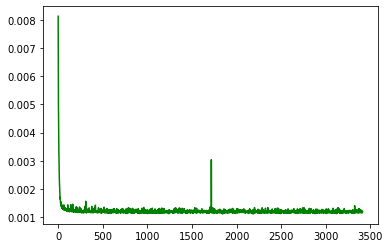

In [17]:
p = plt.figure()
plt.plot(loss_history,'g-',label='h 10,z 2')

In [32]:
test = dataBefore[5000000:5050000]
stepped = tep_testing_stepped(test,3)

C:\Users\Charlie\AppData\Local\Temp/ipykernel_29272/3844283621.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensorZ = torch.tensor(z[0])
C:\Users\Charlie\AppData\Local\Temp/ipykernel_29272/442245058.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  anomalies.append(torch.tensor(anom))


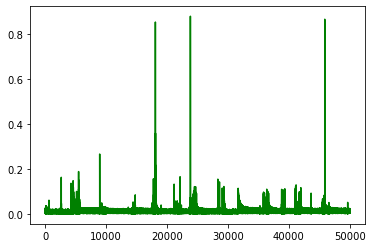

In [34]:
fileLoc = "C:/Users/Charlie/Desktop/picsForDemo2/tepGeneratedLast/NGAFID_Test/demoResult.png"

step_start = 0
anomalies = []
y_nomalies = []
vals = []
pred_vals = []
county = 0
start = 0
view = []
for step in stepped:    
    step = torch.tensor(step)
    step = step.double()
    recon,_,_ = demo(step)
    for j in range(len(step)):
        a = (recon[0][j] - step[0][j])
        anom = a**2
        anomalies.append(torch.tensor(anom))
        pred_vals.append(torch.mean(recon))
        vals.append(torch.mean(step))
        step_start = step_start + 1
        county = county + 1
    for a in anomalies:
        if start+1 < len(anomalies):
            view.append(abs(anomalies[start+1].item() - a.item()))  
            start = start + 1
            
p3 = plt.figure()
plt.plot(anomalies, 'g-')